In [65]:
import contextily as cx
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yaml
from matplotlib.colors import TwoSlopeNorm

with open("../../data/crs.yaml", "r") as fp:
    crs = yaml.safe_load(fp)

with open("../../plotting_config.yaml", "r") as fp:
    config = yaml.safe_load(fp)
    for i in ["png", "pdf"]:
        config["metadata"][i]["Author"] = "Zsófia Zádor"
    config["metadata"]["svg"]["Creator"] = "Zsófia Zádor"

In [1]:
CITY = "madrid"
VERSION = "20250415"
YEAR = 2020

In [ ]:
path = f"../../output/{CITY}/{VERSION}/"

# Read the GeoJSON file where for each stop id we know the multimodal area (5 min walk + 10 min BKK) + ellipticity of this shape + size of the area
# and multipolygons describing the 5 min walk from each such station
multimodal = gpd.read_file(f"{path}/stop_geometries_from_walk.geojson")
# Read GeoJSON file for 15 minute walking distance
walking = gpd.read_file(f"{path}/isochrones.geojson")
# read centrality csv
centrality = pd.read_csv(f"{path}/merged.csv", dtype={"stop_id": str})
# read in geojson for city boundary
boundary = gpd.read_file(f"../../data/osm/{CITY}/boundary.geojson")

# gini
gini = gpd.read_file(f"../../data/statistics/{CITY}/{YEAR}/gini.geojson")
gini.drop(columns=["year", "municipality", "province"], inplace=True)
# Read the file into a DataFrame
socioecon = gpd.read_file(f"../../data/statistics/{CITY}/{YEAR}/income.geojson")

# Pipeline

0. Filter walking to 15min walk
1. match hexagons & other small shapes to walking15 shapes and multimodal
2. Append to socioecon data
3. For multimodal, count average income, nr poor households/total households (poor household %) within area
4. For walking15 count within area
5. Calculate 
    - low income ratio
    - Gini,
    - income entropy -- however how? income level at each location? and characterise low/mid/high income for Gini? 

### Filter walking

In [6]:
walking15 = walking[(walking["costing"] == "walk") & (walking["range"] == 15)]
walking15 = walking15.copy()
walking15.drop(columns=["costing", "range"], inplace=True)

### Match tract shapes to walking and multimodal areas

In [7]:
def add_tract_ids(geo_df, tract_df):
    """
    Adds a column of census tract IDs to a GeoDataFrame based on spatial intersection.

    Parameters:
    geo_df (GeoDataFrame): The input GeoDataFrame with geometries representing walking/multimodal areas.
    socioecon_df (GeoDataFrame): The GeoDataFrame with census tract geometries and tract codes.

    Returns:
    GeoDataFrame: The updated GeoDataFrame with a new column 'tract_code' containing the matched tract codes.
    """

    # Ensure both GeoDataFrames have the same CRS
    if geo_df.crs != tract_df.crs:
        geo_df = geo_df.to_crs(tract_df.crs)

    # Perform spatial join to assign census tract IDs to walking geometries
    geo_tracts = gpd.sjoin(
        geo_df, tract_df[["tract_code", "geometry"]], how="left", predicate="intersects"
    )

    return geo_tracts

In [8]:
walking15_tract = add_tract_ids(walking15, socioecon)

In [9]:
multimodal_tract = add_tract_ids(multimodal, socioecon)

Text(0.5, 1.0, 'Walking Geometry and Census Tracts for stop_id par_5_46')

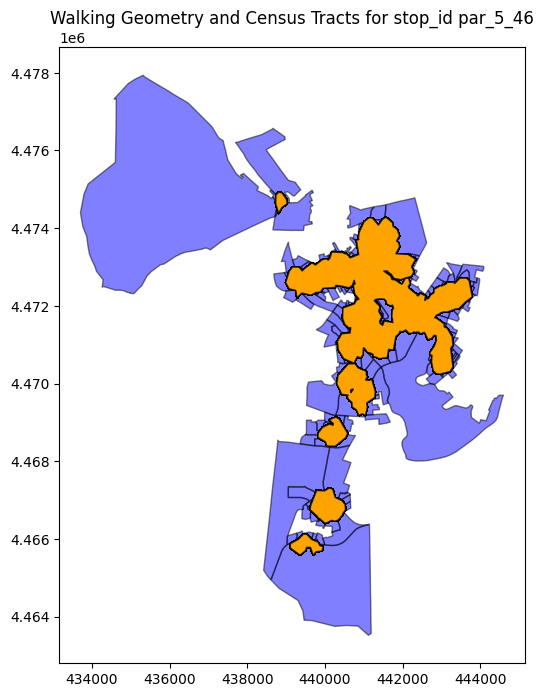

In [10]:
# Choose a stop_id to visualize
stop_id_to_plot = multimodal_tract.iloc[1000].stop_id

# Get all walking geometries for this stop_id
walking_geoms = multimodal_tract[
    multimodal_tract["stop_id"] == stop_id_to_plot
].geometry

# Get all census tracts that overlap with this stop_id
tract_codes = multimodal_tract[multimodal_tract["stop_id"] == stop_id_to_plot][
    "tract_code"
].unique()
tract_geoms = socioecon[
    socioecon["tract_code"].isin(tract_codes)
]  # Get all matching tracts

# Plot both layers on top of each other
fig, ax = plt.subplots(figsize=(8, 8))

# Plot all census tracts associated with the stop_id
tract_geoms.plot(
    ax=ax, color="blue", edgecolor="black", alpha=0.5, label="Census Tracts"
)

# Plot all walking geometries for this stop_id
gpd.GeoSeries(walking_geoms).plot(
    ax=ax, color="orange", edgecolor="black", alpha=0.7, label="Walking Geometry"
)

ax.set_title(f"Walking Geometry and Census Tracts for stop_id {stop_id_to_plot}")

### # 2. Append to socioecon data

In [11]:
def compute_weighted_stat(geo_tract, socioecon, stat_column):
    """
    Computes the weighted average of a specified column (e.g., income or Gini) for each stop_id.

    Parameters:
    geo_tract (GeoDataFrame): Contains stop_id and the corresponding census tract codes.
    socioecon (GeoDataFrame): Contains census tract geometries and the specified statistical column (income, gini etc).
    stat_column (str): The column name in socioecon to be weighted (e.g., 'net_income_hh' or 'gini').

    Returns:
    DataFrame: df with stop_id and the weighted average of the specified column.
    """

    # Merge to include the  statistic and tract geometries
    merged = geo_tract.merge(
        socioecon[["tract_code", "geometry", stat_column]], on="tract_code", how="left"
    )

    # Rename columns
    merged = merged.rename(
        columns={"geometry_x": "stop_geometry", "geometry_y": "tract_geometry"}
    )

    # Set the stop area geometry as the active geometry
    merged = merged.set_geometry("stop_geometry")

    # Ensure both datasets have the same CRS
    if merged.crs != socioecon.crs:
        merged = merged.to_crs(socioecon.crs)

    # Compute intersection area
    merged["intersection"] = merged.apply(
        lambda row: row.stop_geometry.intersection(row.tract_geometry), axis=1
    )
    merged["intersection_area"] = merged["intersection"].area
    merged["tract_area"] = merged["tract_geometry"].area

    # Compute weights: % of tract within stop area
    merged["weight"] = merged["intersection_area"] / merged["tract_area"]

    # Compute weighted statistic for each row
    merged["weighted_stat"] = merged["weight"] * merged[stat_column]

    # Compute weighted average per stop_id
    result = (
        merged.groupby("stop_id")
        .apply(
            lambda g: pd.Series(
                {
                    f"weighted_{stat_column}": g["weighted_stat"].sum()
                    / g["weight"].sum()
                }
            )
        )
        .reset_index()
    )

    return result

In [12]:
# Compute weighted gini
multimodal_weighted_gini_per_stop = compute_weighted_stat(
    multimodal_tract, gini, "gini"
)
# merge with walking shape
multimodal_weighted_gini = multimodal_weighted_gini_per_stop.merge(
    multimodal[["stop_id", "geometry"]], on="stop_id"
)
# Convert result into a GeoDataFrame
multimodal_weighted_gini_gpd = gpd.GeoDataFrame(
    multimodal_weighted_gini, geometry="geometry", crs=multimodal_tract.crs
)

/tmp/ipykernel_40722/950341020.py:47: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(


In [13]:
# Compute weighted gini
walk_weighted_gini_per_stop = compute_weighted_stat(walking15_tract, gini, "gini")
# merge with walking shape
walk_weighted_gini = walk_weighted_gini_per_stop.merge(
    walking15[["stop_id", "geometry"]], on="stop_id"
)
# Convert result into a GeoDataFrame
walk_weighted_gini_gpd = gpd.GeoDataFrame(
    walk_weighted_gini, geometry="geometry", crs=multimodal_tract.crs
)

/tmp/ipykernel_40722/950341020.py:47: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(


In [14]:
# Compute weighted net income
multimodal_weighted_income_per_stop = compute_weighted_stat(
    multimodal_tract, socioecon, "net_income_hh"
)
# merge with multimodal shape
multimodal_weighted_income = multimodal_weighted_income_per_stop.merge(
    multimodal[["stop_id", "geometry"]], on="stop_id"
)
# Convert result into a GeoDataFrame
multimodal_weighted_income_gpd = gpd.GeoDataFrame(
    multimodal_weighted_income, geometry="geometry", crs=multimodal_tract.crs
)

/tmp/ipykernel_40722/950341020.py:47: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(


In [15]:
# Compute weighted net income
walk_weighted_income_per_stop = compute_weighted_stat(
    walking15_tract, socioecon, "net_income_hh"
)
# merge with walk shape
walk_weighted_income = walk_weighted_income_per_stop.merge(
    walking15[["stop_id", "geometry"]], on="stop_id"
)
# Convert result into a GeoDataFrame
walk_weighted_income_gpd = gpd.GeoDataFrame(
    walk_weighted_income, geometry="geometry", crs=multimodal_tract.crs
)

/tmp/ipykernel_40722/950341020.py:47: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(


In [16]:
# Merge the two dataframes on stop_id
gini_change = multimodal_weighted_gini.merge(
    walk_weighted_gini_per_stop[["stop_id", "weighted_gini"]],
    on="stop_id",
    suffixes=("_multi", "_walk"),
    how="left",
)

# Calculate percentage change
gini_change["percent_change_gini"] = (
    (gini_change["weighted_gini_multi"] - gini_change["weighted_gini_walk"])
    / gini_change["weighted_gini_walk"]
) * 100

# NA values if either input is NA
gini_change["percent_change_gini"] = gini_change["percent_change_gini"].where(
    gini_change[["weighted_gini_multi", "weighted_gini_walk"]].notna().all(axis=1)
)

# Calculate log change
gini_change["log_change_gini"] = np.where(
    (gini_change["weighted_gini_multi"] > 0) & (gini_change["weighted_gini_walk"] > 0),
    np.log(gini_change["weighted_gini_multi"] / gini_change["weighted_gini_walk"]),
    np.nan,
)

gini_change_gpd = gpd.GeoDataFrame(
    gini_change, geometry="geometry", crs=multimodal_tract.crs
)

In [17]:
# Merge the two dataframes on stop_id
income_change = multimodal_weighted_income.merge(
    walk_weighted_income_per_stop[["stop_id", "weighted_net_income_hh"]],
    on="stop_id",
    suffixes=("_multi", "_walk"),
    how="left",
)

# Calculate percentage change
income_change["percent_change_income"] = (
    (
        income_change["weighted_net_income_hh_multi"]
        - income_change["weighted_net_income_hh_walk"]
    )
    / income_change["weighted_net_income_hh_walk"]
) * 100

# NA values if either input is NA
income_change["percent_change_income"] = income_change["percent_change_income"].where(
    income_change[["weighted_net_income_hh_multi", "weighted_net_income_hh_walk"]]
    .notna()
    .all(axis=1)
)

# Calculate log change
income_change["log_change_income"] = np.where(
    (income_change["weighted_net_income_hh_multi"] > 0)
    & (income_change["weighted_net_income_hh_walk"] > 0),
    np.log(
        income_change["weighted_net_income_hh_multi"]
        / income_change["weighted_net_income_hh_walk"]
    ),
    np.nan,
)

income_change_gpd = gpd.GeoDataFrame(
    income_change, geometry="geometry", crs=multimodal_tract.crs
)

In [18]:
stop_income_change = income_change.merge(
    centrality[["stop_id", "stop_lat", "stop_lon"]]
)

In [19]:
stop_gini_change = gini_change.merge(centrality[["stop_id", "stop_lat", "stop_lon"]])

In [20]:
stop_gini_change

,stop_id,weighted_gini_multi,geometry,weighted_gini_walk,percent_change_gini,log_change_gini,stop_lat,stop_lon
0,1,39.203981,"POLYGON ((-3.7894 40.4541, -3.78885 40.45482, ...",43.492812,-9.861012,-0.103817,40.470100,-3.782880
1,100,37.083174,"POLYGON ((-3.69498 40.44938, -3.69442 40.45053...",36.796977,0.777776,0.007748,40.457420,-3.685570
2,1000,32.007082,"POLYGON ((-3.68051 40.39258, -3.68327 40.3936,...",32.672600,-2.036931,-0.020580,40.398070,-3.669400
3,1001,31.915741,"POLYGON ((-3.6566 40.38605, -3.65985 40.38459,...",33.046978,-3.423118,-0.034831,40.396760,-3.666460
4,1002,32.204395,"POLYGON ((-3.67924 40.39366, -3.6792 40.39566,...",33.060684,-2.590053,-0.026242,40.396760,-3.665980
...,...,...,...,...,...,...,...,...
5225,par_8_981,31.148611,"POLYGON ((-3.63621 40.4275, -3.63818 40.42758,...",30.563525,1.914327,0.018962,40.431771,-3.628562
5226,par_8_982,30.581080,"POLYGON ((-3.62888 40.42414, -3.63088 40.42486...",30.295257,0.943460,0.009390,40.433186,-3.625097
5227,par_8_983,30.974436,"POLYGON ((-3.63627 40.42778, -3.63635 40.42772...",30.315860,2.172382,0.021491,40.433239,-3.625345
5228,par_8_984,30.400659,"POLYGON ((-3.62888 40.42414, -3.63088 40.42486...",30.138840,0.868711,0.008650,40.434315,-3.622891


In [30]:
stop_income_df = stop_income_change.drop(columns=["geometry", "stop_lat", "stop_lon"])
stop_income_gini = stop_income_df.merge(
    stop_gini_change[
        [
            "stop_id",
            "weighted_gini_multi",
            "weighted_gini_walk",
            "percent_change_gini",
            "log_change_gini",
        ]
    ],
    on="stop_id",
    how="left",
)
stop_income_gini.to_csv(f"../../output/{CITY}/socioecon_change2.csv", index=False)

In [22]:
centrality.drop(columns=["Unnamed: 27"], inplace=True)
stop_income_gini_centr = pd.merge(
    stop_income_gini, centrality, on="stop_id", how="inner"
)
stop_income_gini_centr.to_csv(f"../../output/{CITY}/socioecon_merged2.csv", index=False)

In [23]:
stop_income_gini_centr

,stop_id,weighted_net_income_hh_multi,weighted_net_income_hh_walk,percent_change_income,log_change_income,weighted_gini_multi,weighted_gini_walk,percent_change_gini,log_change_gini,area,...,walk_area,area_difference,stop_name,stop_lat,stop_lon,cluster,eigenvector_centrality,degree_centrality,closeness_centrality,betweenness_centrality
0,1,70683.793624,89273.733903,-20.823527,-0.233491,39.203981,43.492812,-9.861012,-0.103817,4.926,...,2.212,2.714,Avenida Valdemarín - Blanca De Castilla,40.470100,-3.782880,117,4.000652e-08,0.000971,0.065655,0.002099
1,100,64596.007428,68473.225508,-5.662386,-0.058290,37.083174,36.796977,0.777776,0.007748,3.716,...,3.576,0.140,Padre Damián - Lázaro Galdiano,40.457420,-3.685570,1702,4.145335e-04,0.000971,0.091296,0.000854
2,1000,35930.844065,34502.545642,4.139690,0.040563,32.007082,32.672600,-2.036931,-0.020580,5.768,...,3.630,2.138,Puente De Vallecas,40.398070,-3.669400,1658,1.435976e-04,0.002914,0.098300,0.010765
3,1001,32105.638304,32002.357745,0.322728,0.003222,31.915741,33.046978,-3.423118,-0.034831,4.149,...,3.576,0.573,Junta Municipal Puente De Vallecas,40.396760,-3.666460,1656,2.870781e-05,0.001457,0.090042,0.002290
4,1002,36395.710279,31667.007054,14.932587,0.139176,32.204395,33.060684,-2.590053,-0.026242,4.709,...,3.555,1.154,Junta Municipal Puente De Vallecas,40.396760,-3.665980,1656,2.870781e-05,0.001457,0.090042,0.002290
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5225,par_8_981,31825.545240,30103.280261,5.721187,0.055635,31.148611,30.563525,1.914327,0.018962,5.143,...,3.191,1.952,EMILIO MUÑOZ-STA.LEONOR,40.431771,-3.628562,994,7.468572e-06,0.000971,0.075080,0.000816
5226,par_8_982,31591.232094,29849.406559,5.835377,0.056715,30.581080,30.295257,0.943460,0.009390,4.295,...,3.506,0.789,EMILIO MUÑOZ-ALFONSO GOMEZ,40.433186,-3.625097,1021,3.998670e-05,0.000971,0.073966,0.000974
5227,par_8_983,31406.188755,30068.107246,4.450169,0.043540,30.974436,30.315860,2.172382,0.021491,4.666,...,3.436,1.230,EMILIO MUÑOZ-ALFONSO GOMEZ,40.433239,-3.625345,1021,3.998670e-05,0.000971,0.073966,0.000974
5228,par_8_984,31950.449552,29766.751969,7.336029,0.070794,30.400659,30.138840,0.868711,0.008650,5.087,...,3.650,1.437,EMILIO MUÑOZ-MIGUEL YUSTE,40.434315,-3.622891,1022,2.273939e-04,0.001457,0.079189,0.001738


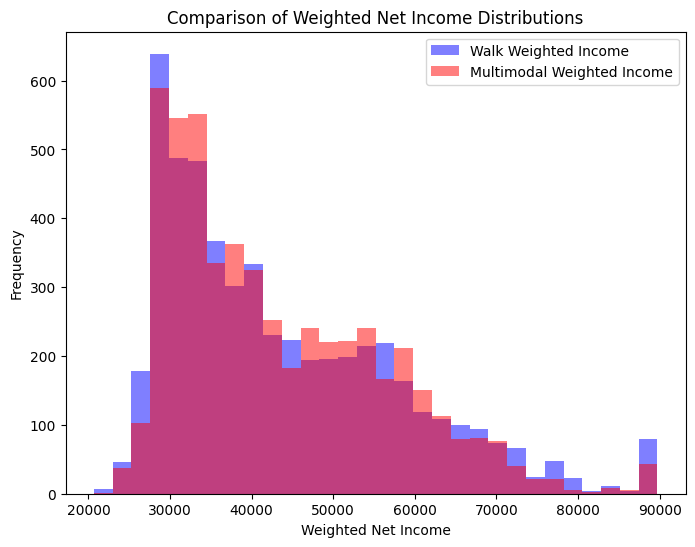

In [26]:
# Plot histograms
plt.figure(figsize=(8, 6))
plt.hist(
    walk_weighted_income_per_stop.weighted_net_income_hh,
    bins=30,
    alpha=0.5,
    color="blue",
    label="Walk Weighted Income",
)
plt.hist(
    multimodal_weighted_income_per_stop.weighted_net_income_hh,
    bins=30,
    alpha=0.5,
    color="red",
    label="Multimodal Weighted Income",
)

# Labels and title
plt.xlabel("Weighted Net Income")
plt.ylabel("Frequency")
plt.title("Comparison of Weighted Net Income Distributions")
plt.legend()

In [27]:
stop_income_change.percent_change_income.min()  # 104 -43

-43.385882760489594

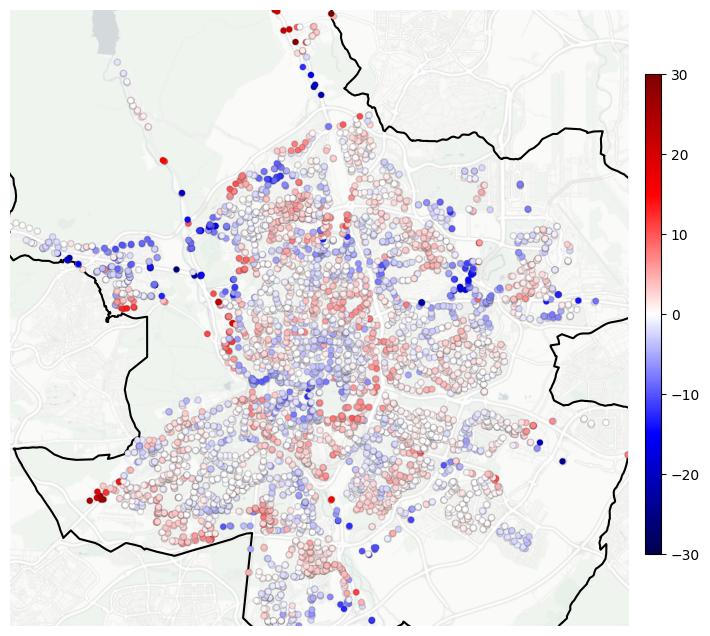

In [66]:
gdf = gpd.GeoDataFrame(
    stop_gini_change,
    geometry=gpd.points_from_xy(
        stop_gini_change["stop_lon"], stop_gini_change["stop_lat"]
    ),
    crs=4326,
).to_crs(crs[CITY])

# Create figure and axis
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_xticks([])
ax.set_yticks([])
ax.set_frame_on(False)

# Set limits to focus on the gdf points
ax.set_xlim(gdf.total_bounds[[0, 2]])  # Set x-limits (lon)
ax.set_ylim(gdf.total_bounds[[1, 3]])  # Set y-limits (lat)

# Color normalization: Centered around 0 with limits (-0.3, 0.3)
norm = TwoSlopeNorm(vmin=-30, vcenter=0, vmax=30)
cmap = "seismic"

# Create colorbar
# caxi = inset_axes(ax, width="2.5%", height="90%", loc=6, borderpad=3.8)
# cbar = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
# fig.colorbar(cbar, cax=caxi,)


# Create colorbar on the right outside the map
cax = fig.add_axes([0.92, 0.2, 0.02, 0.6])  # [left, bottom, width, height]
cbar = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
fig.colorbar(cbar, cax=cax)

# Plot Madrid boundary first to ensure it's visible
boundary.to_crs(crs[CITY]).plot(
    ax=ax,
    edgecolor="black",
    facecolor="none",
    linewidth=1.5,
    label="Madrid Boundary",
)

# Clip and plot the stops inside Madrid
gpd.clip(gdf, boundary.to_crs(crs[CITY])).plot(
    column="percent_change_gini",
    cmap=cmap,
    norm=norm,
    edgecolor="#2d2d2d2d",
    markersize=20,
    ax=ax,
    legend=False,
)

cx.add_basemap(
    ax,
    crs=gdf.crs,
    source=cx.providers.CartoDB.PositronNoLabels,
    alpha=1,
    attribution=False,
)

fig.savefig(f"../../output/{CITY}/gini_change.png", metadata=config["metadata"]["png"])

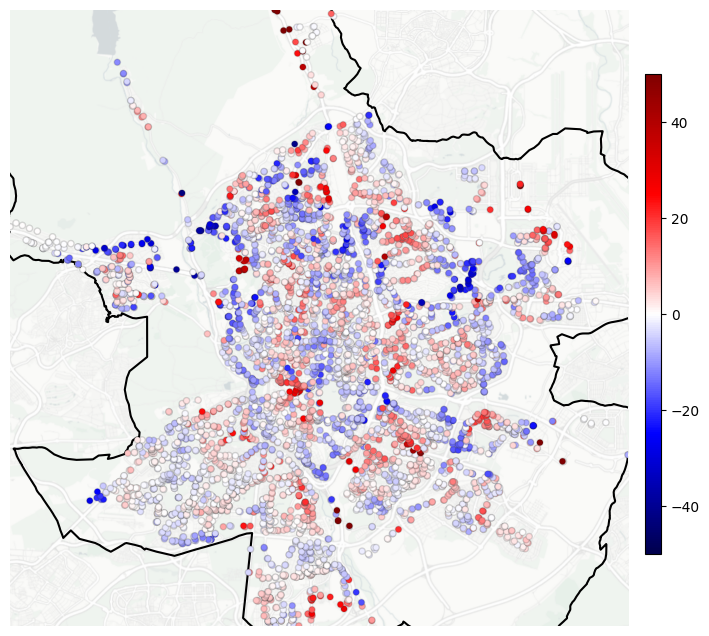

In [67]:
gdf = gpd.GeoDataFrame(
    stop_income_change,
    geometry=gpd.points_from_xy(
        stop_income_change["stop_lon"], stop_income_change["stop_lat"]
    ),
    crs=4326,
).to_crs(crs[CITY])

# Create figure and axis
fig, ax = plt.subplots(figsize=(8, 8))  # , layout="constrained")
ax.set_xticks([])
ax.set_yticks([])
ax.set_frame_on(False)
# Set limits to focus on the gdf points
ax.set_xlim(gdf.total_bounds[[0, 2]])  # Set x-limits (lon)
ax.set_ylim(gdf.total_bounds[[1, 3]])  # Set y-limits (lat)

# Color normalization: Centered around 0 with limits (-0.3, 0.3)
norm = TwoSlopeNorm(vmin=-50, vcenter=0, vmax=50)
cmap = "seismic"

# Create colorbar
# caxi = inset_axes(ax, width="2.5%", height="90%", loc=6, borderpad=3.8)
# cbar = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
# fig.colorbar(cbar, cax=caxi,)


# Create colorbar on the right outside the map
cax = fig.add_axes([0.92, 0.2, 0.02, 0.6])  # [left, bottom, width, height]
cbar = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
fig.colorbar(cbar, cax=cax)
cax.set_facecolor("white")

# Plot Madrid boundary first to ensure it's visible
boundary.to_crs(crs[CITY]).plot(
    ax=ax,
    edgecolor="black",
    facecolor="none",
    linewidth=1.5,
    label="Madrid Boundary",
)

# Clip and plot the stops inside Madrid
gpd.clip(gdf, boundary.to_crs(crs[CITY])).plot(
    column="percent_change_income",
    cmap=cmap,
    norm=norm,
    edgecolor="#2d2d2d2d",
    markersize=20,
    ax=ax,
    legend=False,
)

cx.add_basemap(
    ax,
    crs=gdf.crs,
    source=cx.providers.CartoDB.PositronNoLabels,
    alpha=1,
    attribution=False,
)

fig.savefig(
    f"../../output/{CITY}/income_change.png", metadata=config["metadata"]["png"]
)